## Latest BBC news sentiment

Sentiment Analysis of BBC News tweets collected through the Twitter API real time.

Twitter data is not only gold in terms of insights, but due to often renewals also is available for analysis in near real-time. By monitoring news, we can extract a sentiment – positive, negative or neutral, this helps to understand how the public feels about what's going on in the world.

For performing news sentiment Analysis was chosen BBC News twitter account. They post news every half an hour or even more often.

In [69]:
import tweepy
import pandas as pd

from tweepy import OAuthHandler
from tweepy import API
from tweepy import Stream

import json
from datetime import datetime

import numpy as np 
import re

import nltk
import textblob
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer


import wordcloud
from wordcloud import WordCloud,STOPWORDS

from dateutil import tz

In [70]:
%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns 

The access to Twitter API was performed by using tweepy library through api keys and tokens.

In [71]:
api_key = 'hAFRTiO27RiSTROpCMcXRQUZc'
api_secret = 'n4qdj5KH0mFGYgGbo2Gx9j6eEq6PmOyPIO23JsXs8r5kKCjSXm'
auth = OAuthHandler(api_key, api_secret)
access_token = '880788361979604992-tUkhs43c38chhvrHzCrxT5RlcdkYUYG'
access_token_secret = 'EDVZC0aht9z46K45zD4l267UBVrRwRyHUTALJ9VimrR6M'

bearer_token = r'AAAAAAAAAAAAAAAAAAAAAAtYkgEAAAAAjXLxlYFIgi%2FXiyQP8%2BqaETu50kE%3DlLcOjlaGiGWDehdKqYzOD4K8Ni94P7tzve31sJVSRuWP0O3dk0'

auth.set_access_token(access_token, access_token_secret)

# Set up the API with the authentication handler
api = API(auth)

Getting twitter account ID

In [72]:
#user = api.get_user(screen_name = 'Cobratate')
#user = api.get_user(screen_name = 'FinancialTimes')
user = api.get_user(screen_name = 'BBCWorld')
#user = api.get_user(screen_name = 'BBCBreaking')
user.id

742143

In [73]:
client = tweepy.Client(bearer_token)

In [74]:
# tweets by account

user_id = user.id

response = client.get_users_tweets(user_id,
                                   tweet_fields = ['author_id', 'text', 'geo', 'created_at'],
                                   max_results=100)
 
tweets = response.data

data1=[]

for tweet in tweets:
   
    #print(tweet.author_id)
    #print(tweet.text)
    #print(tweet.geo)
    #print(tweet.created_at)
    data1.append([tweet.id, tweet.text, tweet.created_at])

In [75]:
df = pd.DataFrame(data1, columns = ['Tweet ID', 'Tweet text', 'Time'])

The data indicates tweet id, text of the tweet and tweet time converted to local Warsaw time. 

In [76]:
# converting tweet time to local

df['Warsaw time'] = df['Time'].dt.tz_convert('GMT').dt.tz_convert('Europe/Warsaw')
df = df.drop(['Time'], axis=1)

In [77]:
df.head(10)

,Tweet ID,Tweet text,Warsaw time
0,1615046747218186242,"India cricketer Rishabh Pan says ""road to reco...",2023-01-16 19:02:05+01:00
1,1615043352226893856,Taliban start buying blue ticks on Twitter htt...,2023-01-16 18:48:35+01:00
2,1615039193532465152,Migrants granted right to challenge UK's Rwand...,2023-01-16 18:32:04+01:00
3,1615030991164145677,Moment Italian mafia boss Matteo Messina Denar...,2023-01-16 17:59:28+01:00
4,1615024102221168640,Five ways Elon Musk has changed Twitter for us...,2023-01-16 17:32:06+01:00
5,1615015805166534658,Investigation after two planes nearly collide ...,2023-01-16 16:59:08+01:00
6,1615008484390469632,What weapons are being supplied to Ukraine?\nh...,2023-01-16 16:30:02+01:00
7,1615002633885851648,Moment Italian mafia boss Matteo Messina Denar...,2023-01-16 16:06:47+01:00
8,1615000726618443777,RT @BBCBreaking: Jeremy Clarkson says he has e...,2023-01-16 15:59:13+01:00
9,1614993653889384452,"Nigerian stars Burna Boy, Davido and Wizkid do...",2023-01-16 15:31:06+01:00


In [78]:
#creating a function to clean text from emojis, hashtags, etc.

def clean_text(text):
    # including all possible emojis in a variable
    emoji=re.compile("["
                     u"\U0001F600-\U0001F64F"    #emoticons
                     u"\U0001F300-\U0001F5FF"    #symbol & pictographs
                     u"\U0001F680-\U0001F6FF"    #transport & map
                     u"\U0001F1E0-\U0001F1FF"    #flags
                     u"\U00002500-\U00002BEF"    #chinese char
                     u"\U00002702-\U000027B0"
                     u"\U000024C2-\U0001F251"
                     u"\U0001f926-\U0001f937"
                     u"\U00010000-\U0010ffff"
                     u"\u2640-\u2642" 
                     u"\u2600-\u2B55"
                     u"\u200d"
                     u"\u23cf"
                     u"\u23e9"
                     u"\u231a"
                     u"\ufe0f"    # dingbats
                     u"\u3030"
                              "]+", re.UNICODE)
    text=re.sub('RT','',text)                       #remove 'RT' from tweets
    text=re.sub('#[A-Za-z0-9]+','',text)            #remove hashtags from tweets
    text=re.sub('\\n','',text)                      #remove \n from the tweets
    text=re.sub('https?://\S+|www\.\S+','',text)    #remove the hyperlinks from the tweets
    text=re.sub('@[\S]*','',text)                   #remove the mentions from the tweets
    text=re.sub('[^\w\s]','',text)                  #remove punctuation from the tweets
    text=re.sub('^[\s]+|[\s]+$','',text)            #remove leading & trailing whitespace from the tweets
    text=re.sub(emoji,'',text)                      #remove the emojis from the tweets
    text=text.lower()
    
    return text

In [79]:
#creating new column named CleanedTweets

df['Clean text']=df['Tweet text'].apply(clean_text)
df.head(10)

,Tweet ID,Tweet text,Warsaw time,Clean text
0,1615046747218186242,"India cricketer Rishabh Pan says ""road to reco...",2023-01-16 19:02:05+01:00,india cricketer rishabh pan says road to recov...
1,1615043352226893856,Taliban start buying blue ticks on Twitter htt...,2023-01-16 18:48:35+01:00,taliban start buying blue ticks on twitter
2,1615039193532465152,Migrants granted right to challenge UK's Rwand...,2023-01-16 18:32:04+01:00,migrants granted right to challenge uks rwanda...
3,1615030991164145677,Moment Italian mafia boss Matteo Messina Denar...,2023-01-16 17:59:28+01:00,moment italian mafia boss matteo messina denar...
4,1615024102221168640,Five ways Elon Musk has changed Twitter for us...,2023-01-16 17:32:06+01:00,five ways elon musk has changed twitter for users
5,1615015805166534658,Investigation after two planes nearly collide ...,2023-01-16 16:59:08+01:00,investigation after two planes nearly collide ...
6,1615008484390469632,What weapons are being supplied to Ukraine?\nh...,2023-01-16 16:30:02+01:00,what weapons are being supplied to ukraine
7,1615002633885851648,Moment Italian mafia boss Matteo Messina Denar...,2023-01-16 16:06:47+01:00,moment italian mafia boss matteo messina denar...
8,1615000726618443777,RT @BBCBreaking: Jeremy Clarkson says he has e...,2023-01-16 15:59:13+01:00,jeremy clarkson says he has emailed harry and ...
9,1614993653889384452,"Nigerian stars Burna Boy, Davido and Wizkid do...",2023-01-16 15:31:06+01:00,nigerian stars burna boy davido and wizkid dom...


In [80]:
#creating a function to find out polarity & subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#creating another user define function to label the sentiment 

def getSentiment(value):
    if value<0:
        return 'Negative'
    elif value>0:
        return 'Positive'
    else:
        return 'Neutral'

### Subjectivity and Polarity

Subjectivity tells us how subjective the text content of a Tweet is.
Polarity lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement.
Tweets are described as Negative, Neutral or Positive based on the Polarity score.

In [81]:
df['Polarity']=df['Clean text'].apply(getPolarity)
df['Subjectivity']=df['Clean text'].apply(getSubjectivity)
df['Sentiment']=df['Polarity'].apply(getSentiment)

df.head(10)

,Tweet ID,Tweet text,Warsaw time,Clean text,Polarity,Subjectivity,Sentiment
0,1615046747218186242,"India cricketer Rishabh Pan says ""road to reco...",2023-01-16 19:02:05+01:00,india cricketer rishabh pan says road to recov...,0.000000,0.000000,Neutral
1,1615043352226893856,Taliban start buying blue ticks on Twitter htt...,2023-01-16 18:48:35+01:00,taliban start buying blue ticks on twitter,0.000000,0.100000,Neutral
2,1615039193532465152,Migrants granted right to challenge UK's Rwand...,2023-01-16 18:32:04+01:00,migrants granted right to challenge uks rwanda...,0.285714,0.535714,Positive
3,1615030991164145677,Moment Italian mafia boss Matteo Messina Denar...,2023-01-16 17:59:28+01:00,moment italian mafia boss matteo messina denar...,0.000000,0.000000,Neutral
4,1615024102221168640,Five ways Elon Musk has changed Twitter for us...,2023-01-16 17:32:06+01:00,five ways elon musk has changed twitter for users,0.000000,0.000000,Neutral
5,1615015805166534658,Investigation after two planes nearly collide ...,2023-01-16 16:59:08+01:00,investigation after two planes nearly collide ...,0.118182,0.427273,Positive
6,1615008484390469632,What weapons are being supplied to Ukraine?\nh...,2023-01-16 16:30:02+01:00,what weapons are being supplied to ukraine,0.000000,0.000000,Neutral
7,1615002633885851648,Moment Italian mafia boss Matteo Messina Denar...,2023-01-16 16:06:47+01:00,moment italian mafia boss matteo messina denar...,0.000000,0.000000,Neutral
8,1615000726618443777,RT @BBCBreaking: Jeremy Clarkson says he has e...,2023-01-16 15:59:13+01:00,jeremy clarkson says he has emailed harry and ...,-0.900000,0.700000,Negative
9,1614993653889384452,"Nigerian stars Burna Boy, Davido and Wizkid do...",2023-01-16 15:31:06+01:00,nigerian stars burna boy davido and wizkid dom...,0.000000,0.000000,Neutral


### News share by sentiment

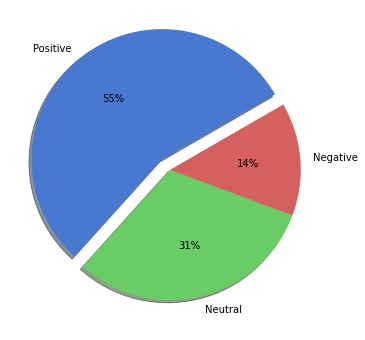

In [82]:
plt.style.use('seaborn-muted')
plt.figure(figsize=(8,6))

values=df['Sentiment'].value_counts()
label=['Positive','Neutral', 'Negative']
explode=[0.1, 0, 0]

plt.pie(values,labels=label,explode=explode,autopct='%.0f%%',shadow=True,startangle=30)
plt.show()

### Wordcloud : To see what is dominating the news articles

The World Cloud allows to visualize how often a certain word appears in Tweets based on its relative size. 
However, some appearing words such as ‘say’, ‘found’, ‘will’ etc. are just verbs that do not give as much useful information. To get rid of the, stopwords were used.
Below are wordclouds created for each sentiment category.

In [83]:
my_stopwords = set(STOPWORDS)
my_stopwords.update(['say', 'says'])

### Negative news wordcloud

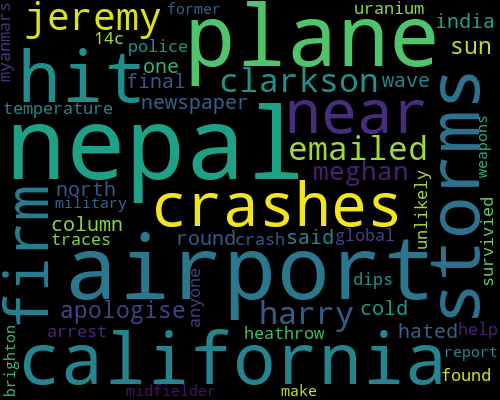

In [84]:
import wordcloud
long_string2 = ' '.join(df.loc[df['Sentiment'] == 'Negative', 'Clean text'])

wordcloud = wordcloud.WordCloud(width=500,height=400, max_words = 50,
                               min_font_size = 9,
                               max_font_size = 100,
                               stopwords = my_stopwords)
wordcloud.generate(long_string2)
wordcloud.to_image()

### Positive news wordcloud

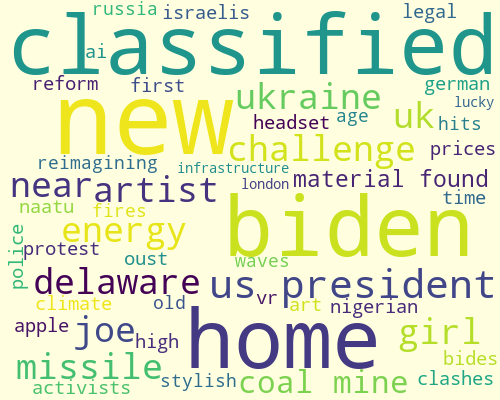

In [85]:
import wordcloud
long_string2 = ' '.join(df.loc[df['Sentiment'] == 'Positive', 'Clean text'])

wordcloud = wordcloud.WordCloud(width=500,height=400, max_words = 50,
                               min_font_size = 9,
                               max_font_size = 100,
                               stopwords = my_stopwords,
                               background_color="lightyellow")

wordcloud.generate(long_string2)
wordcloud.to_image()

### Neutral news wordcloud

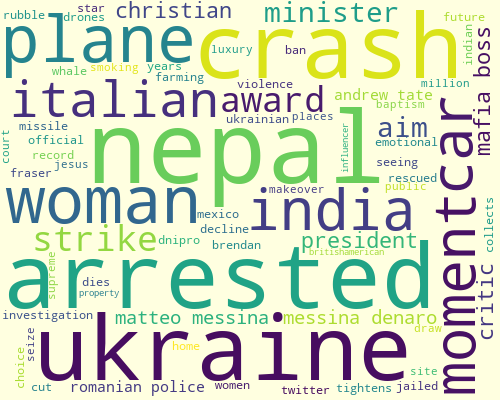

In [86]:
import wordcloud
long_string3 = ' '.join(df.loc[df['Sentiment'] == 'Neutral', 'Clean text'])

wordcloud = wordcloud.WordCloud(width=500,height=400, max_words = 70,
                               min_font_size = 9,
                               max_font_size = 100,
                               stopwords = my_stopwords,
                               background_color="lightyellow")

wordcloud.generate(long_string3)
wordcloud.to_image()

### CountVectorizer to identify common text patterns

CountVectorizer is a scikit-learn package that uses count vectorization to convert a collection of text documents to a matrix of token counts. It helps to identify common text patterns in the documents.
In this example, it is used to perform some basic n-gram analysis of the current news to reveal the underlying topics.


In [87]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['Clean text'], 10)
#for word, freq in common_words:
    #print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['Text' , 'count'])
#df2.groupby('Text').sum()['count'].sort_values(ascending=False)
df2

,Text,count
0,matteo messina denaro,3
1,classified material president,3
2,material president joe,3
3,president joe bidens,3
4,joe bidens delaware,3
5,bidens delaware home,3
6,moment italian mafia,2
7,italian mafia boss,2
8,mafia boss matteo,2
9,boss matteo messina,2


### Conclusions

This project shows data analysis in near real-time. Due to the nature of the topic, only latest tweets were collected and analysed.
The project can be improved later by collecting significantly larger amount of tweets over-time, creating a dataset and using it for training a model to predict news or stock sentiment. 
